# Transfer Learning on a network, where roads are clustered into classes

In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipdb

In [2]:
from keras.models import load_model,Model
from keras.engine.topology import Layer
from keras import backend as K
import tensorflow as tf
import keras 

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
#定义精度评价指标。为防止0值附近相对误差过大而导致的异常，定义mask层。
def mape_loss_func(preds, labels):
    mask = labels > 5
    return np.mean(np.fabs(labels[mask]-preds[mask])/labels[mask])

def smape_loss_func(preds, labels):
    mask= labels > 5
    return np.mean(2*np.fabs(labels[mask]-preds[mask])/(np.fabs(labels[mask])+np.fabs(preds[mask])))

def mae_loss_func(preds, labels):
    mask= labels > 5
    return np.fabs((labels[mask]-preds[mask])).mean()

def eliminate_nan(b):
    a = np.array(b)
    c = a[~np.isnan(a)]
    return c

## 把速度矩阵分类

In [3]:
randseed = 25
res = 11

v = pd.read_csv('../data/v_20_aggragated.csv')
v = v.rename(columns={'Unnamed: 0': 'id'})
id_402 = pd.read_csv('../res/%i_res%i_id_402_withclass.csv'%(randseed, res), index_col=0)
part1 = pd.read_csv('../res/%i_res%i_det_partition_results1.csv'%(randseed, res))
part2 = pd.read_csv('../res/%i_res%i_det_partition_results2.csv'%(randseed, res))

v['class_i'] = ''
for i in range(len(v)):
    v.loc[i, 'class_i'] = id_402[id_402['id']==v.loc[i, 'id']].iloc[0, 5]  # 5 stands for 'class_i'

num_class = id_402['class_i'].drop_duplicates().size

v_class = []
for i in range(num_class):
    v_class.append(v[v['class_i']==i])

print('There are %i class(es)'%num_class)

There are 5 class(es)


## 制作 nearest_road_id.csv 和speed.csv

In [4]:
dist_mat = pd.read_csv('../data/dist_mat.csv', index_col=0)
id_info = pd.read_csv('../data/id2000.csv', index_col=0)
dist_mat.index = id_info['id2']
dist_mat.columns = id_info['id2']
for i in range(len(dist_mat)):
    for j in range(len(dist_mat)):
        if i==j:
            dist_mat.iloc[i, j] = 0

near_id = pd.DataFrame(np.argsort(np.array(dist_mat)), index = id_info['id2'], columns = id_info['id2'])

## 以上做好了near_road矩阵，接下来做flow/speed矩阵

In [5]:
def get_node(det, seg):
    # det is one single detector id
    # node is one single node id
    
    # seg = pd.read_csv('./data/segement.csv', header=None)
    try:
        node_info = seg[seg[6]==det]
        node = node_info.iloc[0, 0]
    except:
        node_info = seg[seg[7]==det]
        node = node_info.iloc[0, 0]
        
    return node

In [6]:
def get_class_with_node(seg, v_class):
    det_list_class = np.array([])
    try:
        v_class.insert(1, 'id2', '')  # id2 mean node id
    except:
        v_class['id2'] = ''
        
    for i in range(len(v_class)):
        det_list_class = np.append(det_list_class, v_class.iloc[i, 0])
        v_class.iloc[i, 1] = get_node(v_class.iloc[i, 0], seg)
    
    return det_list_class, v_class

In [7]:
def rds_mat(old_dist_mat, det_ids):
    # get a matrix that contains roads whose node id s are given (det_ids)
    node_ids = np.array([])
#     ipdb.set_trace()
    for i in det_ids:
        node_ids = np.append(node_ids, get_node(i, seg))
#     ipdb.set_trace()
    new_dist_mat = old_dist_mat.loc[node_ids, node_ids]
    old_dist_mat = np.array(old_dist_mat)
    new_near_id_mat = np.argsort(new_dist_mat)
    return new_near_id_mat

In [8]:
seg = pd.read_csv('../data/segement.csv', header=None)
num_dets = 30

det_list_class = []
for i in range(num_class):
    det_list_class_temp, v_class_temp = get_class_with_node(seg, v_class[i])
    det_list_class.append(det_list_class_temp[:])
    v_class_temp = v_class_temp.loc[v_class_temp['id'].isin(det_list_class_temp[:])]
    v_class[i] = v_class_temp

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### Visulization

In [9]:
def plot_dets(det_list_class_i, if_save):
    
    for i in range(len(id_402)):
        det_id = id_402.loc[i, 'id']
        cls_402 = id_402.loc[i, 'class_i']
        try:
            cls_det = part1[part1['det'] == det_id]['0'].values[0]
            if cls_402 != cls_det:
                part1.loc[part1['det'] == det_id, '0'] = cls_402
                print(i)
        except:
            cls_det = part2[part2['det'] == det_id]['0'].values[0]
            if cls_402 != cls_det:
                part2.loc[part2['det'] == det_id, '0'] = cls_402
                print(i)
    
    
    fig = plt.figure(figsize=[40, 15], dpi=125)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    for i in range(len(det_list_class_i)):
        det_id = det_list_class_i[i]
        x = id_402.loc[id_402['id']==det_id, 'lat']
        y = id_402.loc[id_402['id']==det_id, 'long']
#         ipdb.set_trace()
        if det_id in part1['det'].values:
            ax1.plot(x, y, marker='+', color='red', markersize=10, markerfacecolor='none')
            ax1.text(x-0.005, y, det_id, rotation=45)
        elif det_id in part2['det'].values:
            ax2.plot(x, y, marker='o', color='red', markersize=10, markerfacecolor='none')
            ax2.text(x-0.005, y, det_id, rotation=45)
            
    plt.show()
    if if_save:
        fig.savefig('../network_classification/img/%i_res%i_class_%i.png'%(randseed, res, class_i_))
        print(1)
    plt.close()
    
    return

10
137
138
139
140
142
170
212
341
342
343
344
345
346


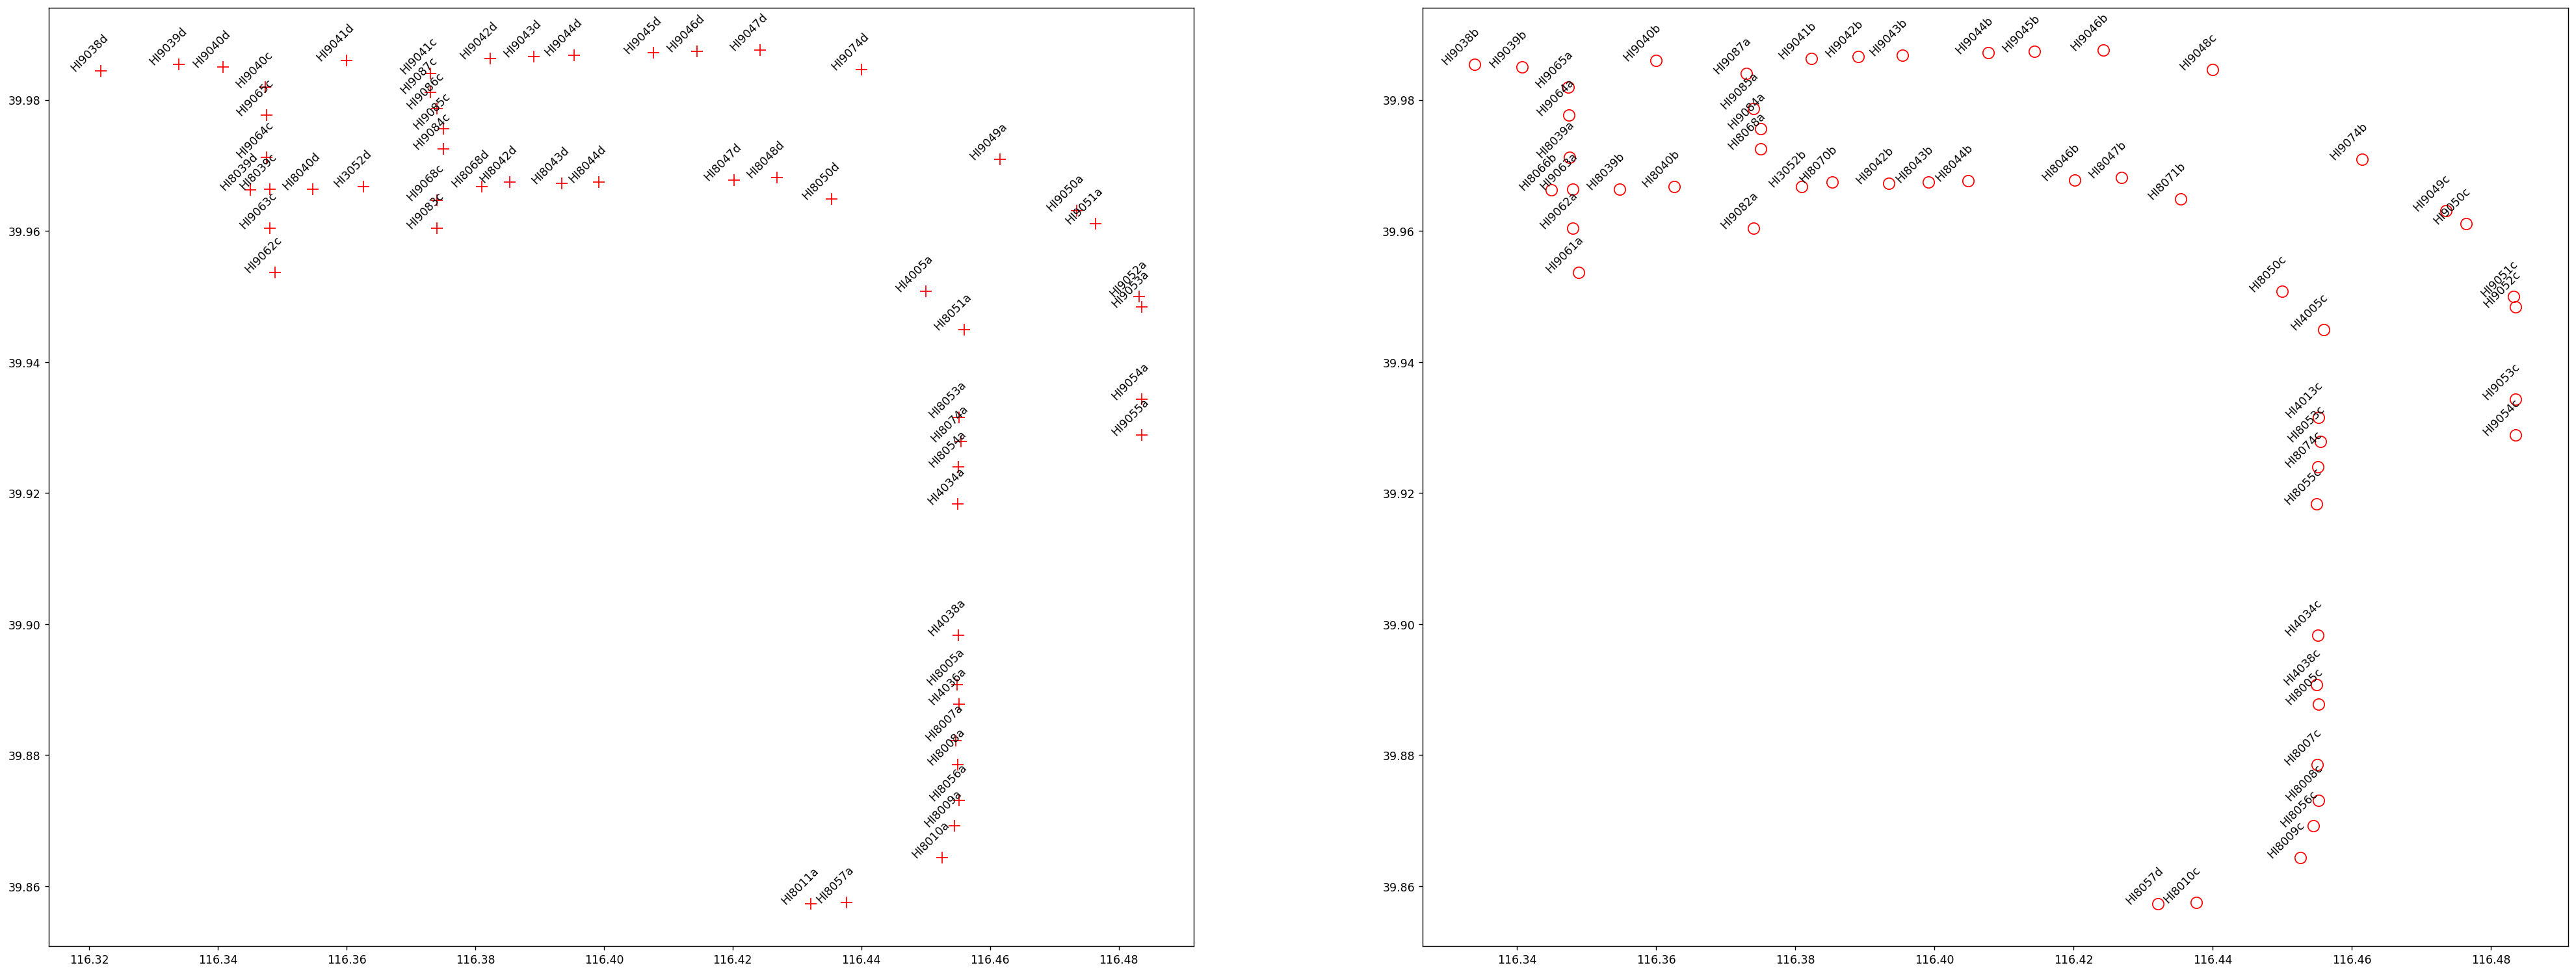

In [10]:
# ind, class
# 0  , blue
# 1  , green
# 2  , yellow  <--
# 3  , black   <--
# 4  , red     <--
class_i_ = 4
plot_dets(det_list_class[class_i_], if_save=0)

### Select detectors manually, then assemble v_class matrix

In [11]:
selected_dets = pd.read_csv('../network_classification/selected_dets.csv', index_col=0)

In [12]:
# filt, so that only selected dets remain
class_set = [2, 3, 4]
for i in range(len(class_set)):
    cls_ = class_set[i]
    det_set = selected_dets.loc[selected_dets['class']==cls_, 'det'].values
    v_class[cls_] = v_class[cls_].loc[v_class[cls_]['id'].isin(det_set)]

In [13]:
# make near_road matrix
near_road_set = []
for i in range(num_class):
    det_set = v_class[i]['id'].values
#     ipdb.set_trace()
    near_road_set.append(rds_mat(dist_mat, det_set))

## Evaluation of 2 datasets

In [14]:
def get_NSk(set1, set2):
    # designated for v_class1 and 2
    set1_v_mean = set1.iloc[:, 2:-1].T.mean().T
    set2_v_mean = set2.iloc[:, 2:-1].T.mean().T
    
    var1 = set1_v_mean.std()**2
    var2 = set2_v_mean.std()**2
    
    u1 = set1_v_mean.mean()
    u2 = set2_v_mean.mean()
    
    return 2*var1 / (var1 + var2 + (u1 - u2)**2)

In [15]:
NSk_set = np.array([])

for i in class_set:
    for j in class_set:
        if i!=j:
            NSk = get_NSk(v_class[i], v_class[j])
            NSk_set = np.append(NSk_set, NSk)

print(NSk_set.mean())

0.948569518962195


# 源代码如下 （训练）

In [76]:
def sliding_window(flow, near_road, from_day, to_day, prop):
    flow = np.array(flow)
    # 选数据
    flow = flow[:, 144*from_day:144*to_day]
    print(flow.shape)

    # 利用滑动窗口的方式，重构数据为(n，最近路段数，输入时间窗，总路段数)的形式

    k = 5 # 参数k为需考虑的最近路段数
    t_p = 10 # 参数t_p为总时间序列长度（天）
    t_input = 12 #参数t_input为输入时间窗(10min颗粒度)
    t_pre = 3 #参数t_pre为预测时间窗(10min颗粒度)
    num_links = 25 #参数num_links为总路段数


    image = []
    for i in range(np.shape(near_road)[0]):
        road_id = []
        for j in range(k):
            road_id.append(near_road[i][j])
        image.append(flow[road_id, :])
    image1 = np.reshape(image, [-1, k, len(flow[0,:])])
    image2 = np.transpose(image1,(1,2,0))
    image3 = []
    label = []
    day = []

    for i in range(1, t_p):
        for j in range(144-t_input-t_pre):
            image3.append(image2[:, i*144+j:i*144+j+t_input, :][:])
            label.append(flow[:, i*144+j+t_input:i*144+j+t_input+t_pre][:])
            day.append(flow[:, (i-1)*144+j+t_input:(i-1)*144+j+t_input+t_pre][:])

    image3 = np.asarray(image3)
    label = np.asarray(label)
    day =  np.asarray(day)

    print(np.shape(image3))

    #划分前90%数据为训练集，最后10%数据为测试集
    image_train = image3[:int(np.shape(image3)[0]*prop)]
    image_test = image3[int(np.shape(image3)[0]*prop):]
    label_train = label[:int(np.shape(label)[0]*prop)]
    label_test = label[int(np.shape(label)[0]*prop):]

    day_train = day[:int(np.shape(day)[0]*prop)]
    day_test = day[int(np.shape(day)[0]*prop):]

    print(image_train.shape)
    print(image_test.shape)
    print(label_train.shape)
    print(label_test.shape)
    
    return image_train, image_test, label_train, label_test

In [77]:
# ind, class
# 0  , blue
# 1  , green
# 2  , yellow  <--
# 3  , black   <--
# 4  , red     <--
class_src = 2
v_class1 = v_class[class_src]  # source
near_road1 = np.array(near_road_set[class_src])

class_tar = 4
v_class2 = v_class[class_tar]  # target
near_road2 = np.array(near_road_set[class_tar])

In [81]:
near_road_src = near_road1
flow_src = v_class1.iloc[:, 2:-1]
prop = 1  # proportion of training data

image_train_source, image_test_source, label_train_source, label_test_source = sliding_window(
    flow_src, near_road_src, from_day=20, to_day=30, prop=prop
)

(25, 1440)
(1161, 5, 12, 25)
(1161, 5, 12, 25)
(0, 5, 12, 25)
(1161, 25, 3)
(0, 25, 3)


In [82]:
near_road_tar = near_road2
flow_tar = v_class2.iloc[:, 2:-1]
prop = 0.3

image_train_target, image_test_target, label_train_target, label_test_target = sliding_window(
    flow_tar, near_road_tar, from_day=20, to_day=30, prop=prop
)

(25, 1440)
(1161, 5, 12, 25)
(348, 5, 12, 25)
(813, 5, 12, 25)
(348, 25, 3)
(813, 25, 3)


In [20]:
# 定义融合层，将深度学习算法与历史均值算法融合
class Merge_Layer(Layer):
    def __init__(self, **kwargs):
        super(Merge_Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.para1 = self.add_weight(shape=(input_shape[0][1], input_shape[0][2]),
                                     initializer='uniform', trainable=True,
                                     name='para1')
        self.para2 = self.add_weight(shape=(input_shape[1][1], input_shape[1][2]),
                                     initializer='uniform', trainable=True,
                                     name='para2')
        super(Merge_Layer, self).build(input_shape)

    def call(self, inputs):
        mat1 = inputs[0]
        mat2 = inputs[1]
        output = mat1 * self.para1 + mat2 * self.para2
        # output = mat1 * 0.1 + mat2 * 0.9
        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0]

In [21]:
#模型构建
input_data = keras.Input(shape=(k,t_input,num_links), name='input_data')
input_HA = keras.Input(shape=(num_links, t_pre), name='input_HA')

x = keras.layers.BatchNormalization(input_shape =(k,t_input,num_links))(input_data)

x = keras.layers.Conv2D(
                           filters = num_links,
                           kernel_size = 3,
                           strides = 1,
                           padding="SAME",
                           activation='relu')(x)

x = keras.layers.AveragePooling2D(pool_size = (2,2),
                                strides = 1,
                                padding = "SAME",
                                )(x)

x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(
                       filters = num_links,
                       kernel_size = 3,
                       strides = 1,
                       padding="SAME",
                       activation='relu')(x)

x = keras.layers.AveragePooling2D(pool_size = (2,2),
                                strides = 1,
                                padding = "SAME",
                                )(x)
x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(num_links*2*t_pre, activation='relu', name='dense_1')(x)
x = keras.layers.Dense(num_links*t_pre, activation='relu', name='dense_2')(x)

output = keras.layers.Reshape((num_links,t_pre))(x)

output_final = Merge_Layer()([output, input_HA])

# construct model
finish_model = keras.models.Model([input_data,input_HA], [output_final])

finish_model.summary()









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         (None, 5, 12, 25)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 5, 12, 25)    100         input_data[0][0]                 
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 5, 12, 25)    5650        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
average_pooling2d_1 (AveragePoo (None, 5, 12, 25)    0           conv2d_1[0][0]       

In [22]:
#参数加载
finish_model.load_weights('../model/source_black.h5')
#模型预测
model_pre = finish_model.predict([image_test_target, day_test_target])

In [23]:
#预测结果存储
# model_pre = np.reshape(model_pre,[103, 6])
# model_pre1 = pd.DataFrame(model_pre)
# model_pre1.to_csv('预测值.csv', index = False)

In [24]:
#transfer without FT 预测精度计算
mape_mean = mape_loss_func(model_pre, label_test_target)
smape_mean = smape_loss_func(model_pre, label_test_target)
mae_mean = mae_loss_func(model_pre, label_test_target)

print('mape = ' + str(mape_mean) + '\n' + 'smape = ' + str(smape_mean) + '\n' + 'mae = ' + str(mae_mean))

mape = 0.28538258543333633
smape = 0.31538997218679643
mae = 15.29083165554665


In [25]:
# from sklearn import metrics
def mmd (x, y):
    return np.abs(x.mean() - y.mean())

In [26]:
import scipy.stats
def norm_data(data):
    min_ = min(data)
    max_ = max(data)
    normalized_data = data - min_ / (max_ - min_)
    return normalized_data
    
def js_divergence(set1, set2):
    p = np.array(set1.iloc[:, 2:-1].T.mean().T)
    q = np.array(set2.iloc[:, 2:-1].T.mean().T)
    M=(p+q)/2
    return 0.5*scipy.stats.entropy(p,M)+0.5*scipy.stats.entropy(q, M)
    # return scipy.stats.entropy(p, q)  # kl divergence

In [27]:
def new_loss(output_final, label_train_target):
    middle1 = Model(inputs=[input_data, input_HA], outputs=finish_model.get_layer('dense_1').output)
    middle2 = Model(inputs=[input_data, input_HA], outputs=finish_model.get_layer('dense_2').output)
    
    middle_result_source1 = middle1.predict([image_train_source, day_train_source])
    middle_result_target1 = middle1.predict([image_train_target, day_train_target])

    middle_result_source2 = middle2.predict([image_train_source, day_train_source])
    middle_result_target2 = middle2.predict([image_train_target, day_train_target])

    lamb = js_divergence(v_class1.iloc[:, 2:-1], v_class2.iloc[:, 2:-1])

    loss1 = K.mean(K.square(output_final - label_train_target), axis=-1) 
    loss2 = lamb * ( mmd(middle_result_source1, middle_result_target1) + mmd(middle_result_source2, middle_result_target2) )
#     loss2 = 0.001 * mmd(middle_result_source2, middle_result_target2)
    print('Lambda is %.4f'%lamb)
    overall_loss = loss1 + loss2
    
    return overall_loss


In [28]:
finish_model.compile(optimizer='adam', loss=new_loss)


Lambda is 0.0137


In [29]:
finish_model.fit([image_train_target, day_train_target], label_train_target, epochs=300, batch_size=462,
validation_data=([image_test_target,day_test_target], label_test_target))

Train on 1138 samples, validate on 2657 samples
Epoch 1/300
1138/1138 [==============================] - 1s 611us/step - loss: 469.5964 - val_loss: 377.1218
Epoch 2/300
1138/1138 [==============================] - 0s 100us/step - loss: 339.3903 - val_loss: 331.2555
Epoch 3/300
1138/1138 [==============================] - 0s 87us/step - loss: 287.5459 - val_loss: 300.4922
Epoch 4/300
1138/1138 [==============================] - 0s 85us/step - loss: 253.6565 - val_loss: 260.3719
Epoch 5/300
1138/1138 [==============================] - 0s 83us/step - loss: 228.2898 - val_loss: 231.9496
Epoch 6/300
1138/1138 [==============================] - 0s 87us/step - loss: 213.2551 - val_loss: 218.8610
Epoch 7/300
1138/1138 [==============================] - 0s 86us/step - loss: 205.5317 - val_loss: 210.9353
Epoch 8/300
1138/1138 [==============================] - 0s 88us/step - loss: 197.3404 - val_loss: 206.4715
Epoch 9/300
1138/1138 [==============================] - 0s 87us/step - loss: 194.2661

Epoch 76/300
1138/1138 [==============================] - 0s 85us/step - loss: 142.0646 - val_loss: 154.7845
Epoch 77/300
1138/1138 [==============================] - 0s 88us/step - loss: 140.6349 - val_loss: 152.7912
Epoch 78/300
1138/1138 [==============================] - 0s 84us/step - loss: 139.5406 - val_loss: 151.1981
Epoch 79/300
1138/1138 [==============================] - 0s 82us/step - loss: 139.0553 - val_loss: 154.3942
Epoch 80/300
1138/1138 [==============================] - 0s 83us/step - loss: 139.1187 - val_loss: 153.8967
Epoch 81/300
1138/1138 [==============================] - 0s 85us/step - loss: 138.6193 - val_loss: 151.2398
Epoch 82/300
1138/1138 [==============================] - 0s 82us/step - loss: 139.5510 - val_loss: 149.7367
Epoch 83/300
1138/1138 [==============================] - 0s 81us/step - loss: 137.9039 - val_loss: 152.9977
Epoch 84/300
1138/1138 [==============================] - 0s 84us/step - loss: 137.1698 - val_loss: 151.5480
Epoch 85/300
1138/1

1138/1138 [==============================] - 0s 84us/step - loss: 110.3127 - val_loss: 137.4165
Epoch 225/300
1138/1138 [==============================] - 0s 84us/step - loss: 109.8135 - val_loss: 139.1709
Epoch 226/300
1138/1138 [==============================] - 0s 82us/step - loss: 109.3787 - val_loss: 140.9672
Epoch 227/300
1138/1138 [==============================] - 0s 85us/step - loss: 110.7223 - val_loss: 138.2431
Epoch 228/300
1138/1138 [==============================] - 0s 84us/step - loss: 110.0086 - val_loss: 141.4577
Epoch 229/300
1138/1138 [==============================] - 0s 82us/step - loss: 110.2732 - val_loss: 141.2536
Epoch 230/300
1138/1138 [==============================] - 0s 86us/step - loss: 109.4772 - val_loss: 137.1777
Epoch 231/300
1138/1138 [==============================] - 0s 82us/step - loss: 109.3904 - val_loss: 139.4416
Epoch 232/300
1138/1138 [==============================] - 0s 88us/step - loss: 108.8016 - val_loss: 139.9067
Epoch 233/300
1138/1138 

In [30]:
model_pre = finish_model.predict([image_test_target, day_test_target])

In [31]:
#模型保存
finish_model.save_weights('../model/transfer_DAN_black_r.h5')

In [32]:
#transfer with DAN 预测精度计算

mape_mean = mape_loss_func(model_pre, label_test_target)
smape_mean = smape_loss_func(model_pre, label_test_target)
mae_mean = mae_loss_func(model_pre, label_test_target)

print('mape = ' + str(mape_mean) + '\n' + 'smape = ' + str(smape_mean) + '\n' + 'mae = ' + str(mae_mean))

mape = 0.15767227034110762
smape = 0.1549111670681314
mae = 7.856138271500595


In [33]:
mape_list = []
for i in range(num_links):
    a1 = mape_loss_func(model_pre[:,i,:], label_test_target[:,i,:])
    mape_list.append(a1)

mape_pd = pd.Series(mape_list)
mape_pd.sort_values()

21    0.029507
20    0.036573
13    0.044326
12    0.053192
18    0.084152
10    0.107434
7     0.107814
9     0.110013
16    0.110717
8     0.117683
0     0.143596
24    0.151635
5     0.160769
4     0.160854
23    0.167286
6     0.168788
1     0.172305
11    0.177106
2     0.214069
3     0.227496
15    0.235636
19    0.238353
14    0.273856
22    0.310933
17    0.337714
dtype: float64